# 04 — Error Analysis

In this notebook, we dig into **where the model makes mistakes**.

We will:
1) Load the test split and the best checkpoint  
2) Recompute predictions **with probabilities** (softmax)  
3) Compute **per-class metrics** (precision/recall/F1/support)  
4) Plot **confusion matrices** (counts and normalized)  
5) Rank **worst-performing classes** and **most confused class pairs**  
6) Inspect **hardest mistakes** (highest-confidence wrong predictions)  


## 1) Imports and device


In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support
)

import sys
sys.path.append('../src')

from model import MLPClassifier
from data_loader import HumanActivityDataset
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device:", device)


✅ Device: cpu


## 2) Load processed test data (and optional class names)

We load `X_test_scaled` and `y_test_encoded` from `processed_data.pkl`.


In [3]:
with open("../data/processed_data.pkl", "rb") as f:
    X_train_final, y_train_final, X_val, y_val, X_test_scaled, y_test_encoded = pickle.load(f)

# Try to load class names if available (optional file)
class_names = None
label_names_path = "../data/label_classes.pkl"
if os.path.exists(label_names_path):
    with open(label_names_path, "rb") as f:
        class_names = pickle.load(f)  # e.g., array(['LAYING','SITTING',...])
        class_names = list(class_names)

if class_names is None:
    # Fallback to numeric labels 0..5
    n_classes = len(np.unique(y_test_encoded))
    class_names = [str(i) for i in range(n_classes)]

print("Test samples:", len(y_test_encoded))
print("Class names:", class_names)


Test samples: 2947
Class names: ['0', '1', '2', '3', '4', '5']


## 3) Recreate the model and load the best weights

We rebuild the same MLP architecture and load the best checkpoint saved during training (`../outputs/best_model.pth`). Then we set `eval()` mode for inference.


In [4]:
model = MLPClassifier(
    input_dim=561,
    hidden_dims=[256, 128],
    output_dim=6,
    dropout_rate=0.3
).to(device)

state_dict = torch.load("../outputs/best_model.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("✅ Model loaded.")


✅ Model loaded.


## 4) Test loader and inference with probabilities

We build a `DataLoader` for the test set and compute:
- `logits` → raw scores
- `probs`  → softmax over logits (class probabilities)
- `preds`  → argmax over probs (predicted class indices)


In [5]:
test_dataset = HumanActivityDataset(X_test_scaled, y_test_encoded)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

softmax = nn.Softmax(dim=1)
y_true, y_pred = [], []
y_prob = []  # store the predicted probability of the chosen class

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        logits = model(inputs)
        probs = softmax(logits)
        preds = probs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        # confidence of chosen class
        chosen_conf = probs.max(dim=1).values.cpu().numpy()
        y_prob.extend(chosen_conf)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print("✅ Inference complete.")


✅ Inference complete.


## 5) Per-class metrics (precision, recall, F1, support)

We compute class-wise precision/recall/F1/support using `precision_recall_fscore_support`.
We'll also sort classes by **F1** (ascending) to spotlight the weakest classes.


In [8]:
prec, rec, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=np.arange(len(class_names)), zero_division=0
)

metrics_table = []
for idx, name in enumerate(class_names):
    metrics_table.append((name, prec[idx], rec[idx], f1[idx], support[idx]))

# sort by F1 ascending
metrics_table_sorted = sorted(metrics_table, key=lambda x: x[3])

print("Class  | Precision | Recall |   F1   | Support")
print("-----------------------------------------------")
for name, p, r, f, s in metrics_table_sorted:
    print(f"{name:6} |  {p:8.4f} | {r:6.4f} | {f:6.4f} | {s:7d}")


Class  | Precision | Recall |   F1   | Support
-----------------------------------------------
1      |    0.9421 | 0.8941 | 0.9175 |     491
2      |    0.9034 | 0.9492 | 0.9258 |     532
5      |    0.9615 | 0.9554 | 0.9585 |     471
4      |    0.9685 | 0.9524 | 0.9604 |     420
3      |    0.9606 | 0.9839 | 0.9721 |     496
0      |    1.0000 | 0.9926 | 0.9963 |     537


## 6) Bar charts: per-class Precision / Recall / F1

These bar charts quickly highlight classes with lower precision or recall (e.g., systematic false positives/negatives).


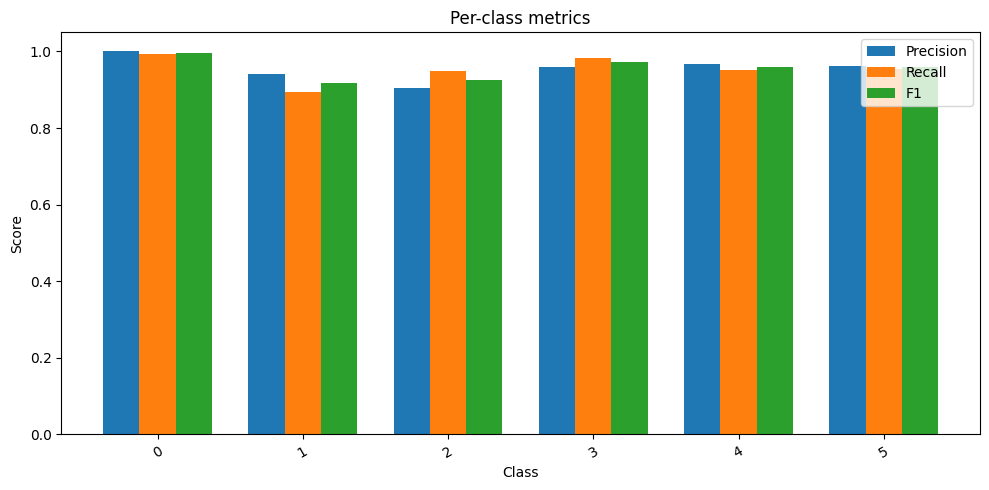

In [9]:
x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(10,5))
plt.bar(x - width, prec, width, label='Precision')
plt.bar(x,         rec,  width, label='Recall')
plt.bar(x + width, f1,   width, label='F1')
plt.xticks(x, class_names, rotation=30)
plt.ylim(0, 1.05)
plt.title("Per-class metrics")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


## 7) Confusion Matrix (counts)

Shows the number of predictions for each (true, predicted) pair.
Look for large off-diagonal cells: they indicate **systematic confusions** between specific classes.


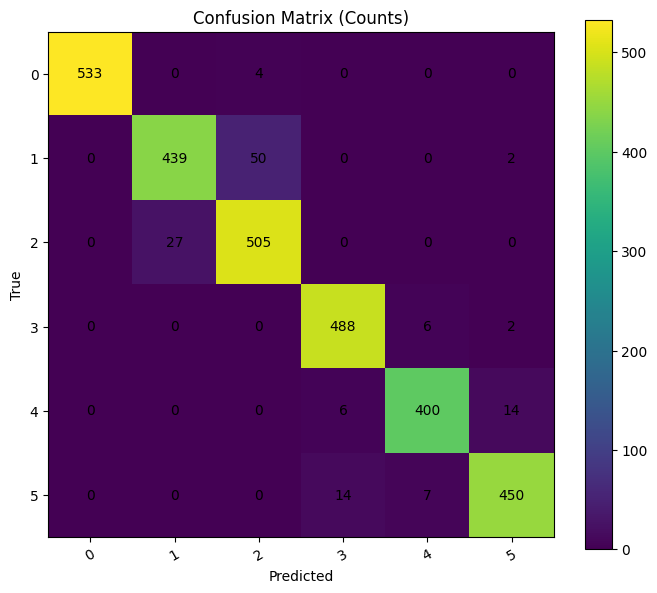

In [10]:
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
fig, ax = plt.subplots(figsize=(7,6))

im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(
    title="Confusion Matrix (Counts)",
    xlabel="Predicted",
    ylabel="True"
)
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=30)
ax.set_yticklabels(class_names)

# annotate
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()


## 8) Confusion Matrix (row-normalized)

Row-normalized confusion shows **rates** instead of counts — easier to compare across classes with different supports.
Each row sums to 1 (100%).


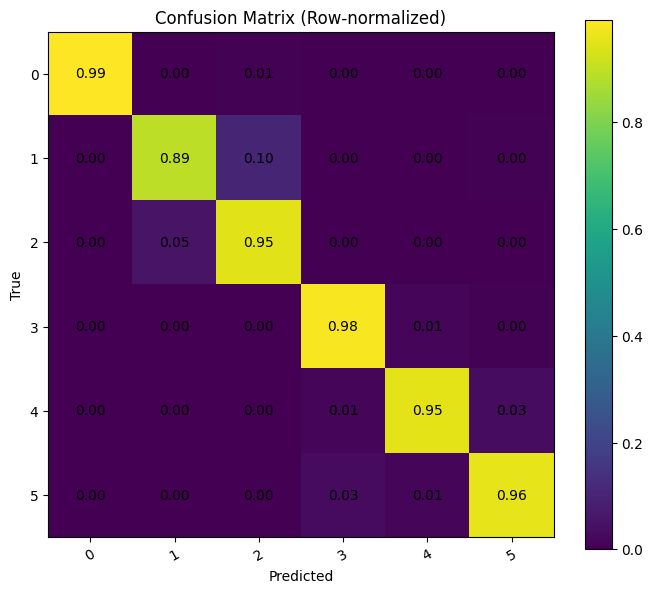

In [11]:
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(7,6))

im = ax.imshow(cm_norm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(
    title="Confusion Matrix (Row-normalized)",
    xlabel="Predicted",
    ylabel="True"
)
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=30)
ax.set_yticklabels(class_names)

# annotate with rates
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")

plt.tight_layout()
plt.show()


## 9) Most confused class pairs

We list the **top off-diagonal cells** in the confusion matrix (highest counts),
which are the most frequent mistakes (true → predicted).


In [12]:
pairs = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i, j] > 0:
            pairs.append((class_names[i], class_names[j], int(cm[i, j]), cm_norm[i, j]))

# sort by count desc, then by normalized rate desc
pairs_sorted = sorted(pairs, key=lambda x: (x[2], x[3]), reverse=True)

print("Top confused class pairs (True -> Pred, count, rate):")
for t, p, cnt, rate in pairs_sorted[:10]:
    print(f"{t:>18} -> {p:<18} | count={cnt:4d} | rate={rate:0.3f}")


Top confused class pairs (True -> Pred, count, rate):
                 1 -> 2                  | count=  50 | rate=0.102
                 2 -> 1                  | count=  27 | rate=0.051
                 4 -> 5                  | count=  14 | rate=0.033
                 5 -> 3                  | count=  14 | rate=0.030
                 5 -> 4                  | count=   7 | rate=0.015
                 4 -> 3                  | count=   6 | rate=0.014
                 3 -> 4                  | count=   6 | rate=0.012
                 0 -> 2                  | count=   4 | rate=0.007
                 1 -> 5                  | count=   2 | rate=0.004
                 3 -> 5                  | count=   2 | rate=0.004


## 10) High-confidence wrong predictions

We inspect the **hardest errors**: cases where the model was **very confident** (high softmax probability)
but still predicted the wrong class. This can reveal **systematic feature patterns** that fool the model.

> Tip: for deeper analysis, you can pull the raw feature vectors or even look back at the corresponding subjects/sessions.


In [13]:
# Build an index aligned with test set order
indices = np.arange(len(y_true))

wrong = (y_true != y_pred)
wrong_idx = indices[wrong]
wrong_conf = y_prob[wrong]           # confidence of the (wrong) predicted class
wrong_true = y_true[wrong]
wrong_pred = y_pred[wrong]

# Sort wrong predictions by descending confidence
order = np.argsort(-wrong_conf)
wrong_idx_sorted = wrong_idx[order]
wrong_conf_sorted = wrong_conf[order]
wrong_true_sorted = wrong_true[order]
wrong_pred_sorted = wrong_pred[order]

top_k = min(10, len(wrong_idx_sorted))
print(f"Top {top_k} high-confidence mistakes:")
for i in range(top_k):
    idx = wrong_idx_sorted[i]
    print(f"[#{idx:4d}] true={class_names[wrong_true_sorted[i]]:>18}  "
          f"pred={class_names[wrong_pred_sorted[i]]:<18}  "
          f"conf={wrong_conf_sorted[i]:.3f}")


Top 10 high-confidence mistakes:
[#1091] true=                 1  pred=2                   conf=1.000
[#1090] true=                 1  pred=2                   conf=1.000
[#1086] true=                 1  pred=2                   conf=1.000
[#1088] true=                 1  pred=2                   conf=1.000
[#1089] true=                 1  pred=2                   conf=1.000
[#1152] true=                 3  pred=4                   conf=1.000
[#1083] true=                 1  pred=2                   conf=1.000
[# 791] true=                 1  pred=5                   conf=1.000
[#1087] true=                 1  pred=2                   conf=1.000
[#1079] true=                 1  pred=2                   conf=1.000


## 11) Summary & next steps

- Use the per-class metrics and confusion matrices to identify **weak classes**.
- Check the **most confused pairs** to decide where to focus improvements.
- Inspect **high-confidence errors** to uncover misleading patterns.

**Ideas to try next:**
- Slightly deeper MLP (e.g., `[512, 256, 128]`) with tuned dropout (0.2–0.4)
- Weight decay (L2) in the optimizer
- Learning rate scheduling (e.g., ReduceLROnPlateau)
- Ensembling: train 2–3 seeds and average logits
- Try a simple **1D CNN** on the 561-vector treated as an ordered sequence (sometimes helps)
